In [1]:
'''
tempotron model based off: 
Gütig, R., Sompolinsky, H. The tempotron: a neuron that learns spike timing–based decisions.
Nat Neurosci 9, 420–428 (2006). https://doi.org/10.1038/nn1643
'''

import numpy as np
from matplotlib import pyplot as plt


np.random.seed(0)

# biophysical parameters
Tmax = 100
dt = 1
t = np.arange(0, Tmax, dt)
tau = 10
tau_s = tau/4
v0 = 2.12
learningRate = 0.001
numInputCells = 50

In [2]:
# create one spike pattern that should cause a spike (positive) and one spike pattern that should not cause a spike(negative)

afferents = np.arange(0, numInputCells)
pos_pattern_times = np.random.randint(0, Tmax, (numInputCells))
neg_pattern_times = np.random.randint(0, Tmax, (numInputCells))

spikePatternPos = np.zeros((numInputCells, Tmax))
for neuron in range(numInputCells):
    spikePatternPos[neuron, pos_pattern_times[neuron]] = 1

spikePatternNeg = np.zeros((numInputCells, Tmax))
for neuron in range(numInputCells):
    spikePatternNeg[neuron, neg_pattern_times[neuron]] = 1

In [3]:
# Training

spike_patterns = {1: spikePatternPos, -1: spikePatternNeg}
spike_times = {1: pos_pattern_times, -1: neg_pattern_times}


numBatches = 10000
kernelT = v0 * (np.exp(-t/tau) - np.exp(-t/tau_s))


weights = np.random.random((1, numInputCells))/10


for i in range(numBatches):

    #calculate tempotron response to spike pattern
    K = np.zeros((numInputCells, t.size))

    if np.random.random() < 0.50:
        pattern = 1
        spikePattern = spikePatternPos
    else:
        pattern = -1
        spikePattern = spikePatternNeg

    for j in range(numInputCells):
        timeSpike = spike_times[pattern][j]
        K[j, :] =  np.concatenate( (np.zeros(timeSpike), kernelT[:Tmax-timeSpike]) )
    tempotronPSP = np.dot(weights, K)[0]
    idx_max = np.argmax(tempotronPSP)
    v_max = tempotronPSP[idx_max]

    if ( v_max > 1 and pattern < 0 ) or ( v_max < 1 and pattern > 0 ):
        #fires and was not supposed tos
        wi_update = np.zeros(numInputCells)
        spikeTimes = spike_times[pattern]
        for k in range(len(spikeTimes)):
            diff = t[idx_max] - spikeTimes[k]
            if diff > 0:
                wi_update[k] += v0 * (np.exp(-diff/tau) - np.exp(-diff/tau_s))

        if pattern < 0:
            weights -= learningRate*wi_update
        elif pattern > 0:
            weights += learningRate*wi_update


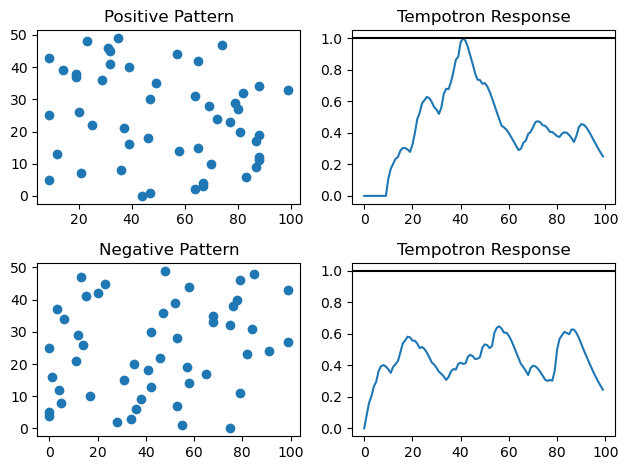

In [4]:
#Plot positive pattern and tempotron response, as well as negative pattern and tempotron response

plt.figure()


# plot positive pattern response
K = np.zeros((numInputCells, t.size))
pattern = 1
spikePattern = spikePatternPos

for j in range(numInputCells):
    K[j,:] = np.convolve(spikePattern[j, :], kernelT)[:t.size]
tempotronPSP_Pos = np.dot(weights, K)[0]

ax = plt.subplot(2, 2, 1)
ax.set_title("Positive Pattern")
plt.scatter(pos_pattern_times, afferents)

ax = plt.subplot(2, 2, 2)
ax.set_title("Tempotron Response")
plt.plot(t, tempotronPSP_Pos)

plt.axhline(y=1, color='k', linestyle='-')


# plot negative pattern response
K = np.zeros((numInputCells, t.size))
pattern = -1
spikePattern = spikePatternNeg

for j in range(numInputCells):
    K[j,:] = np.convolve(spikePattern[j, :], kernelT)[:t.size]
tempotronPSP_Neg = np.dot(weights, K)[0]

ax = plt.subplot(2, 2, 3)
ax.set_title("Negative Pattern")
plt.scatter(neg_pattern_times, afferents)

ax = plt.subplot(2, 2, 4)
ax.set_title("Tempotron Response")
plt.plot(t, tempotronPSP_Neg)

plt.axhline(y=1, color='k', linestyle='-')
plt.tight_layout()
plt.show()
